In [1]:
%load_ext autoreload

In [2]:
%autoreload

import numpy as np
from numpy.linalg import multi_dot
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy
from scipy.interpolate import interp1d
import math as m
import scipy.constants as p
import pandas as pd
import matplotlib.pyplot as plt
import timeit
import sys
sys.path.append("..")
import physics
sys.path.append("../..")
from spec.spectrum import *
import spec.spectools as spectools
#%run 'Electrons_v1.ipynb' might need things form this later
import xsecs
np.set_printoptions(precision=20)

In [3]:
class Rates(object):
    '''
    Allows for easier storage of all xsecs/rates (probabilities)
    Made specifically for ion and heating ONLY.
    
    Attributes
    -----------
    E_spec : Spectrum class
        Electron energy and dNdE spectrum
    n : int
        The bin of interest in the spectrum
    den : ndarray
        density of [H, He, He+] in cm^-3
    rates : ndarray
        dN/dt; Filled with various rates in s^-1
    dNdW : ndarray
        ()()()
    '''
    
    def __init__(self, E_spec, n, den=[1,1,1], dNdW=np.zeros((2,1)), rates=np.zeros(4)):
        '''Return a Rate object with electron of energy *E_spec.eng[n]*
        in a universe with densities *den*; initializes *rate* vector'''
        self.energy = E_spec.eng[n]
        self.n = n
        self.dNdE = E_spec.dNdE[n]
        self.den = den
        self.rates = rates
        self.v = np.sqrt(2*np.array([E_spec.eng[n]])/physics.me)*physics.c 
        self.mult = self.den*self.v
        self.dNdW = np.zeros((2, self.n ))
    
    def ion_dNdW_calc_H(self): #uses new integration method
        '''Fills *self.dNdW[0,:]* with the discretized singly differential xsec in rate form
        '''
        eng_temp = E_spec.eng[0:self.n]
        ion_s_rates = xsecs.ionize_s_cs_H(self.energy, eng_temp) #possible problem with np type
        self.dNdW[0] = ion_s_rates *self.mult[0] #dNdE?
        return self.dNdW
    
    def ion_rate_calc(self):
        '''Fills *self.rate[1:3]* vector by calculating total xsec and then converting to rate
        '''
        ion_rates = xsecs.ionize_cs(self.energy*np.ones(3),np.array([1,2,3]))*self.mult
        self.rates[1:4] = ion_rates
        return self.rates
    
    def heat_rate_calc(self, x_e, rs):
        '''Fills *self.rate[0]* vector with fraction going to heating
            x_e and rs...
        '''
        dE = xsecs.heating_dE(self.energy, x_e, rs, nH=physics.nH)
        delta_dNdE = np.zeros(len(E_spec.dNdE))
        np.put(delta_dNdE, self.n, self.dNdE)
        delta = Spectrum(E_spec.eng, delta_dNdE, rs)
        shift_delta_eng = E_spec.eng+dE
        delta.shift_eng(shift_delta_eng)
        delta.rebin(E_spec.eng)
        
        heating_frac = delta.dNdE[self.n]/self.dNdE
        self.rates[0] = 1-heating_frac
        return(self.rates)
    def tot_sum(self):
        '''Sums all elements of rate
        '''
        tot_sum = sum(self.rates)
        return tot_sum
    def con_prob(self):
        '''Finds cumulative probability of each process
        '''
        con_prob = self.rates/self.tot_sum()
        return con_prob
    def E_loss(self):
        '''loss fraction
        '''
        E_loss_ion=13.6*self.rates[1]
        E_loss_heat=(E_spec.eng[self.n]-E_spec.eng[self.n-1])*self.rates[0]
        E_frac = E_loss_ion/E_loss_heat
        return(E_frac)
    def ion_int_calc(self):
        '''gives total ionization rate
        '''
        bin_width = get_log_bin_width(E_spec.eng[0:self.n])
        integ = 0
        for i in range(self.n):
            integ += self.dNdW[0,i-1]*bin_width[i]*E_spec.eng[i]
        return integ
        
        

In [4]:
eng1 = np.logspace(0.,4.,num = 500)
dNdE1 = np.logspace(0.,5.,num = 500)
rs=1000
E_spec = Spectrum(eng1,dNdE1,rs)
photon_spec = Spectrum(E_spec.eng,np.zeros(len(E_spec.eng)),rs)
TM=np.zeros([len(photon_spec.eng)+2,len(E_spec.eng)]) #possibly make pandas
Transfer_Matrix=pd.DataFrame(TM) #or np.zeros
#print(Transfer_Matrix)
print(np.array([E_spec.eng[330]]))
print(xsecs.ionize_cs(np.array([E_spec.eng[100]]),np.ones(1)))

[ 441.86599563859414274702]
[ 0.]


In [5]:
a = Rates(E_spec, 300)
# print(a.dNdW)
#a.ion_dNdW_calc_H()
#print(a.dNdW[0])
#print(a.ion_int_calc())
#print(a.energy)
#print(a.ion_rate_calc())
# print(a.heat_rate_calc(0.0001, 300))
# print(a.tot_sum())
# print(a.con_prob())
# print(a.rates)


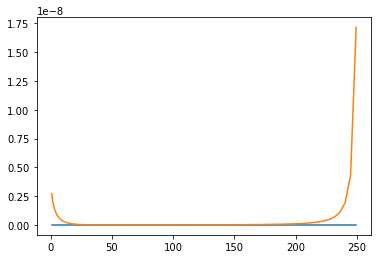

In [6]:
x_test = E_spec.eng[0:300]
y_test_1 = a.dNdW[0]
y_test_2 = xsecs.ionize_s_cs(E_spec.eng[300]*np.ones(300),x_test,np.ones(300))*a.mult[0]
plt.plot(x_test, y_test_1)
plt.plot(x_test, y_test_2)
plt.show()

In [33]:
def electron_low_e(E_spec, rs, ion_frac=[0.001,0.001,0.001], den=[1,1,1], dt=1, photon_abscissa=E_spec.eng ,all_outputs=False):
    '''
    Finds transfer matrix for a given initial electron spectrum
    Outputs: photon spectrum, transfer matrix, E_loss to each process
    '''
    
    N = len(E_spec.eng)
    
    #initialize rate-loss array such that initially, all rates go to heating
    R = np.zeros((2,N))
    R[1,0] = 1
    R[1,1] = 1
    R[1,2] = 1
    
    
    #Initialize photon spectrum (change from current pre-set when important)
        #photon_spec = Spectrum(photon_abscissa,np.zeros(len(E_spec.eng)),rs)
    
    
    #calculate non-ionized atomic densities
    den[0]=(physics.nH*(1-ion_frac[0]))*(rs)**3
    den[1]=(physics.nHe*(1-ion_frac[1])*(1-ion_frac[2]))*(rs)**3
    den[2]=(physics.nHe*(1-ion_frac[1])*(ion_frac[2]))*(rs)**3 #unsure about how ionfrac works for helium
    
    
    
    for n in range(3,N):
        e_rates = Rates(E_spec, n, den)
        e_rates.ion_rate_calc()
        e_rates.heat_rate_calc(ion_frac[1], rs)
        e_rates.ion_dNdW_calc_H()
        
        delta_E_spec = np.ediff1d(E_spec.eng)[0:(n)] #bin widths
        
        discrete_dN_dEdt_i = e_rates.dNdW[0]
        
        h_init=np.zeros(n)
        h_init[n-2] = e_rates.rates[0]
        h_init[n-1] = 1 - e_rates.rates[0]
        discrete_dN_dEdt_h = h_init/delta_E_spec
        
        
        

        
        #confused about R[i,n] since we need to include those contributions, but we don't know that energy loss yet, counting up
        
        
        R_in = ((13.6*e_rates.rates[1]) + np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_i[0:n-1]*R[0,0:n-1]*delta_E_spec[0:n-1]) \
            + np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*R[0,0:n-1]*delta_E_spec[0:n-1])) \
            /(e_rates.energy*(np.sum(discrete_dN_dEdt_i[0:n-1])+np.sum(discrete_dN_dEdt_h[0:n-1])))
            #1-discrete_dN_dEdt_i[n-1]*delta_E_spec[n-1]-discrete_dN_dEdt_h[n-1]*delta_E_spec[n-1])
        
        R_hn = ((e_rates.energy*e_rates.rates[0]-np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*delta_E_spec[0:n-1])) \
            + np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_i[0:n-1]*R[1,0:n-1]*delta_E_spec[0:n-1]) \
            + np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*R[1,0:n-1]*delta_E_spec[0:n-1])) \
            /(e_rates.energy*(np.sum(discrete_dN_dEdt_i[0:n-1])+np.sum(discrete_dN_dEdt_h[0:n-1])))
            #1-discrete_dN_dEdt_i[n-1]*delta_E_spec[n-1]-discrete_dN_dEdt_h[n-1]*delta_E_spec[n-1])

        R[0,n] = R_in/(R_in+R_hn)
        R[1,n] = R_hn/(R_in+R_hn)
        
        print(n, e_rates.energy,R_in,R_hn)
        print(e_rates.energy*e_rates.rates[0], np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*delta_E_spec[0:n-1]), np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_i[0:n-1]*R[1,0:n-1]*delta_E_spec[0:n-1]),np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h[0:n-1]*R[1,0:n-1]*delta_E_spec[0:n-1]) )
        #if n==216:
            #print(n, e_rates.energy,R_in,R_hn)
            #print(e_rates.rates,discrete_dN_dEdt_i, discrete_dN_dEdt_h,delta_E_spec)
            #print(discrete_dN_dEdt_i[n-1], delta_E_spec[n-1],discrete_dN_dEdt_h[n-1])
        
        
    return R
    

In [39]:
#%%prun
results_ion_frac_0 = electron_low_e(E_spec,10**9)

../../darkhistory/spec/spectools.py:30: RuntimeWarning: invalid value encountered in log
  log_bin_width_low = np.log(eng[1]) - np.log(eng[0])
../../darkhistory/spec/spectools.py:31: RuntimeWarning: invalid value encountered in log
  log_bin_width_upp = np.log(eng[-1]) - np.log(eng[-2])
../../darkhistory/spec/spectools.py:37: RuntimeWarning: invalid value encountered in log
  low_lim = np.exp(np.log(eng[0]) - log_bin_width_low / 2)
../../darkhistory/spec/spectools.py:38: RuntimeWarning: invalid value encountered in log
  upp_lim = np.exp(np.log(eng[-1]) + log_bin_width_upp / 2)
../spec/spectrum.py:689: RuntimeWarning: divide by zero encountered in true_divide
  new_dNdE = self.totN('bin')/(new_eng * new_log_bin_width)
../spec/spectrum.py:689: RuntimeWarning: invalid value encountered in true_divide
  new_dNdE = self.totN('bin')/(new_eng * new_log_bin_width)
../spec/spectrum.py:510: RuntimeWarning: invalid value encountered in multiply
  return dNdlogE * log_bin_width
../spec/spectrum.p

3 1.05693455356 0.0 0.0180895715864
1.05693455356 1.01862899024 14196871664.8 1.01862899024
4 1.07662417705 0.0 0.0182662792433
1.07662417705 1.03760501977 16767855999.8 1.03760501977
5 1.09668059834 0.0 0.0184718530211
1.09668059834 1.05693455356 18544648957.5 1.05693455356
6 1.1171106505 0.0 0.0186995885695
1.1171106505 1.07662417705 19905098637.5 1.07662417705
7 1.13792129392 0.0 0.0189453945972
1.13792129392 1.09668059834 21023482811.3 1.09668059834
8 1.1591196186 0.0 0.019206604679
1.1591196186 1.1171106505 21991017857.8 1.1171106505
9 1.18071284667 0.0 0.0194813980784
1.18071284667 1.13792129392 22859930998.0 1.13792129392
10 1.20270833477 0.0 0.0197684889222
1.20270833477 1.1591196186 23662210249.5 1.1591196186
11 1.2251135766 0.0 0.0200669468321
1.2251135766 1.18071284667 24418506409.8 1.18071284667
12 1.24793620547 0.0 0.0203760873616
1.24793620547 1.20270833477 25142728430.4 1.20270833477
13 1.27118399687 0.0 0.0206954019344
1.27118399687 1.2251135766 25844577890.1 1.22511357

97 5.99176966931 0.0 0.0929054030131
5.99176966931 5.77461515236 111946088841.0 5.77461515236
98 6.10339028803 0.0 0.0946358500301
6.10339028803 5.8821904017 113478650740.0 5.8821904017
99 6.21709028616 0.0 0.0963989533541
6.21709028616 5.99176966931 115024571447.0 5.99176966931
100 6.33290840046 0.0 0.0981953292165
6.33290840046 6.10339028803 116583896196.0 6.10339028803
101 6.45088408927 0.0 0.100025605534
6.45088408927 6.21709028616 118156671190.0 6.21709028616
102 6.57105754604 0.0 0.101890422118
6.57105754604 6.33290840046 119742943642.0 6.33290840046
103 6.69346971296 0.0 0.103790430894
6.69346971296 6.45088408927 121342761818.0 6.45088408927
104 6.81816229494 0.0 0.105726296114
6.81816229494 6.57105754604 122956175074.0 6.57105754604
105 6.94517777382 0.0 0.107698694582
6.94517777382 6.69346971296 124583233896.0 6.69346971296
106 7.07455942282 0.0 0.109708315879
7.07455942282 6.81816229494 126223989941.0 6.81816229494
107 7.20635132129 0.0 0.111755862589
7.20635132129 6.94517777

180 27.7259075986 59.1178056543 0.000981003701342
27.7259075986 26.7210615508 660158814.839 0.000560631624593
181 28.2424132608 61.1786615328 0.000904967089262
28.2424132608 27.2188479458 603851090.927 0.000507465655141
182 28.7685409019 63.2651372908 0.000835475388707
28.7685409019 27.7259075986 552768036.958 0.000460077405422
183 29.3044697697 65.3769313039 0.000771922520299
29.3044697697 28.2424132608 506393773.581 0.000417761288361
184 29.8503824512 67.5137242898 0.000713768457052
29.8503824512 28.7685409019 464270259.541 0.000379910508629
185 30.4064649347 69.6751796279 0.000660530827676
30.4064649347 29.3044697697 425989843.929 0.000346001450714
186 30.9729066733 71.8609436813 0.000611777741229
30.9729066733 29.8503824512 391188909.267 0.000315580815561
187 31.5499006496 74.070646122 0.00056712163339
31.5499006496 30.4064649347 359542426.308 0.000288254973377
188 32.137643441 76.3039002596 0.000526213970791
32.137643441 30.9729066733 330759273.935 0.000263681112423
189 32.7363352

112.746795824 108.660611385 97962134.488 0.000117845528913
257 114.847154784 252.576845522 0.000279667248583
114.847154784 110.684848855 98791567.3596 0.000120887295844
258 116.98664131 254.809685087 0.000284031009766
116.98664131 112.746795824 99602582.1319 0.000123993598659
259 119.16598431 257.013707786 0.000288374305226
119.16598431 114.847154784 100394709.601 0.000127165069925
260 121.385926269 259.186943728 0.00029269297378
121.385926269 116.98664131 101167554.116 0.000130402409197
261 123.647223505 261.330065027 0.000296985901232
123.647223505 119.16598431 101920769.142 0.000133706367923
262 125.950646426 263.440886181 0.000301248873258
125.950646426 121.385926269 102654073.339 0.000137077767506
263 128.296979789 265.519564261 0.000305480402407
128.296979789 123.647223505 103367228.153 0.000140517473074
264 130.687022974 267.56507322 0.000309677765443
130.687022974 125.950646426 104060049.174 0.000144026417023
265 133.12159025 269.576405945 0.000313838318501
133.12159025 128.296

333 467.023438833 297.4120843 0.000436083220388
467.023438833 450.097512961 111443504.267 0.000657147777104
334 475.723613919 296.090228818 0.000435061394501
475.723613919 458.482375139 111166853.307 0.000670825725345
335 484.585864482 294.725086294 0.000433962420173
484.585864482 467.023438833 110884639.954 0.000684776434228
336 493.613209824 293.317684573 0.00043278763976
493.613209824 475.723613919 110597038.807 0.000699005420017
337 502.808725494 291.868707176 0.000431537895676
502.808725494 484.585864482 110304221.279 0.000713518307982
338 512.175544336 290.378989636 0.000430214260419
512.175544336 493.613209824 110006355.58 0.000728320834581
339 521.716857555 288.849479597 0.000428817979569
521.716857555 502.808725494 109703606.762 0.000743418849571
340 531.435915805 287.280772411 0.000427349782412
531.435915805 512.175544336 109396136.993 0.000758818318203
341 541.336030297 285.673928689 0.000425811095349
541.336030297 521.716857555 109084105.458 0.000774525323521
342 551.420573

412 2007.26730356 134.727300261 0.000226318308045
2007.26730356 1934.51965374 82298352.0339 0.00324009495513
413 2044.66066658 132.804254287 0.000223415010732
2044.66066658 1970.5578015 81923785.7706 0.00330532513747
414 2082.75063019 130.899857379 0.000220533090635
2082.75063019 2007.26730356 81550536.5345 0.00337185244524
415 2121.55017136 129.014011514 0.000217672546003
2121.55017136 2044.66066658 81178636.3517 0.00343970243077
416 2161.07250881 127.147155522 0.00021483428075
2161.07250881 2082.75063019 80808116.3992 0.00350890114676
417 2201.33110749 125.299245717 0.000212018385727
2201.33110749 2121.55017136 80439007.2747 0.00357947514926
418 2242.33968322 123.470564561 0.0002092255035
2242.33968322 2161.07250881 80071338.8075 0.0036514515147
419 2284.1122073 121.661158082 0.000206455877399
2284.1122073 2201.33110749 79705140.2209 0.00372485784294
420 2326.66291133 119.871165613 0.000203709909163
2326.66291133 2242.33968322 79340440.0596 0.00379972227314
421 2370.00629201 118.1007

490 8469.45980831 39.639320536 7.3680836273e-05
8469.45980831 8162.50851429 58730662.9623 0.0151376558758
491 8627.23729246 39.0170563832 7.26066853789e-05
8627.23729246 8314.56780577 58518612.8129 0.0154373154219
492 8787.95401182 38.4054494621 7.1549574392e-05
8787.95401182 8469.45980831 58309134.427 0.0157428460698
493 8951.66472138 37.8043508607 7.05093015231e-05
8951.66472138 8627.23729246 58102236.2043 0.0160543617637
494 9118.42519615 37.2135917415 6.94856262166e-05
9118.42519615 8787.95401182 57897926.5454 0.0163719786312
495 9288.29225017 36.633013727 6.8478325786e-05
9288.29225017 8951.66472138 57696213.8009 0.0166958150423
496 9461.32375589 36.0624627976 6.74871840998e-05
9461.32375589 9118.42519615 57497106.2846 0.0170259916378
497 9637.57866384 35.5017729833 6.65119610637e-05
9637.57866384 9288.29225017 57300612.3129 0.0173626313816
498 9817.11702275 34.9508023167 6.55524599767e-05
9817.11702275 9461.32375589 57106740.1322 0.0177058596027
499 10000.0 34.409382466 6.4608433

In [37]:
results_ion_frac_0 = electron_low_e(E_spec,100)

3 1.05693455356 0.0 0.0189760123832
7.70251550165e-07 7.42335990566e-07 1.41968716648e-11 7.42335990566e-07
4 1.07662417705 0.0 0.0193295090709
7.63175778316e-07 7.35516659786e-07 1.67678559998e-11 7.35516659786e-07
5 1.09668059834 0.0 0.0196895916541
7.56165011176e-07 7.28759977805e-07 1.85446489575e-11 7.28759977805e-07
6 1.1171106505 0.0 0.0200563826288
7.49218641667e-07 7.22065359548e-07 1.99050986375e-11 7.22065359548e-07
7 1.13792129392 0.0 0.0204300068278
7.42336087709e-07 7.1543224403e-07 2.10234828113e-11 7.1543224403e-07
8 1.1591196186 0.0 0.0208105914482
7.35516753826e-07 7.08860057357e-07 2.19910178578e-11 7.08860057357e-07
9 1.18071284667 0.0 0.0211982660821
7.28760069414e-07 7.02348249604e-07 2.2859930998e-11 7.02348249604e-07
10 1.20270833477 0.0 0.021593162753
7.22065449182e-07 6.95896256694e-07 2.36622102495e-11 6.95896256694e-07
11 1.2251135766 0.0 0.0219954159558
7.1543232762e-07 6.89503533609e-07 2.44185064098e-11 6.89503533609e-07
12 1.24793620547 0.0 0.02240516269

3.35671121673e-07 3.2350568403e-07 1.0594855615e-10 3.2350568403e-07
94 5.66900727121 0.0 0.101775238423
3.32587669043e-07 3.20533982303e-07 1.07428117282e-10 3.20533982303e-07
95 5.77461515236 0.0 0.103671084624
3.29532403001e-07 3.17589445621e-07 1.08920865116e-10 3.17589445621e-07
96 5.8821904017 0.0 0.105602243849
3.26505261436e-07 3.14672014125e-07 1.10426841441e-10 3.14672014125e-07
97 5.99176966931 0.0 0.107569373774
3.23505904292e-07 3.11781360084e-07 1.11946088841e-10 3.11781360084e-07
98 6.10339028803 0.0 0.109573144325
3.20534147005e-07 3.08917305621e-07 1.1347865074e-10 3.08917305621e-07
99 6.21709028616 0.0 0.111614237899
3.1758969481e-07 3.06079566656e-07 1.15024571447e-10 3.06079566656e-07
100 6.33290840046 0.0 0.1136933496
3.14672237318e-07 3.03267844048e-07 1.16583896196e-10 3.03267844048e-07
101 6.45088408927 0.0 0.115811187474
3.11781549807e-07 3.0048192122e-07 1.1815667119e-10 3.0048192122e-07
102 6.57105754604 0.0 0.117968472755
3.08917492699e-07 2.97721663652e-07 

168 22.2174078106 0.260988696481 0.201497335608
1.68005374487e-07 1.61916501257e-07 1.39762664706e-10 7.87888342242e-08
169 22.631295684 0.279125415526 0.195146934514
1.66462143333e-07 1.60429200092e-07 1.34403668929e-10 7.39251663615e-08
170 23.0528938705 0.297626417196 0.188766028779
1.64932847842e-07 1.58955329533e-07 1.29047077724e-10 6.92541464157e-08
171 23.4823460055 0.316411555022 0.182443536769
1.63418284827e-07 1.57495657513e-07 1.23731354366e-10 6.48041041402e-08
172 23.9197984002 0.335500531047 0.176169649064
1.61917184448e-07 1.56048960214e-07 1.18472022354e-10 6.05616776298e-08
173 24.3654000913 0.354826242819 0.170021068734
1.60429482392e-07 1.54615175655e-07 1.1330200028e-10 5.65465602114e-08
174 24.8193028919 0.374406217015 0.163989313968
1.58956414018e-07 1.53195494422e-07 1.0823430846e-10 5.27456895858e-08
175 25.2816614433 0.39418784861 0.158138239311
1.57495664087e-07 1.51787685185e-07 1.03295799677e-10 4.9170690004e-08
176 25.7526332677 0.414188438592 0.1524596241

238 80.8752490877 2.71528505248 0.106696036581
8.80644816677e-08 8.48728369562e-08 2.05779641972e-11 3.30255324255e-09
239 82.381873314 2.78577575785 0.107878976777
8.72558669846e-08 8.40935281946e-08 2.04586908373e-11 3.22521223081e-09
240 83.9165644283 2.85793959885 0.1090910604
8.64533632125e-08 8.33201088714e-08 2.03448069631e-11 3.15024272082e-09
241 85.4798452884 2.93173691685 0.110334467726
8.5661143064e-08 8.25566004714e-08 2.02367113027e-11 3.07781072789e-09
242 87.0722484924 3.00729576218 0.111607583774
8.48737663097e-08 8.17977599306e-08 2.01338756142e-11 3.00752010815e-09
243 88.6943165601 3.0845747119 0.112913014441
8.40953786499e-08 8.10475827004e-08 2.0036284383e-11 2.93955688977e-09
244 90.3466021181 3.16367163489 0.114248396278
8.33227003378e-08 8.03029078989e-08 1.9943390196e-11 2.87357847502e-09
245 92.0296680876 3.2445872932 0.115616547803
8.25574504221e-08 7.9565392273e-08 1.98552929471e-11 2.80969594119e-09
246 93.7440878766 3.32737802408 0.117015407903
8.17987382

309 299.884423123 14.4775236465 0.292163868091
4.57526875643e-08 4.40945125483e-08 2.00368374086e-11 8.82246614319e-10
310 305.470967116 14.7959923627 0.29682425539
4.53200768887e-08 4.36775806066e-08 2.01026678116e-11 8.68921321485e-10
311 311.161582782 15.1170393781 0.301561914114
4.49085324979e-08 4.32809514626e-08 2.01702756955e-11 8.56154213249e-10
312 316.958208873 15.4439301312 0.3063569035
4.45020313028e-08 4.28891827381e-08 2.02376477352e-11 8.43484026383e-10
313 322.862820254 15.7764996822 0.311255833946
4.41013615426e-08 4.25030341049e-08 2.03080573414e-11 8.31287876082e-10
314 328.877428583 16.1188730259 0.316226877256
4.36890872264e-08 4.21057014896e-08 2.03800609985e-11 8.18992841185e-10
315 335.004082991 16.466863655 0.321291770736
4.32843074378e-08 4.17155917841e-08 2.04547259222e-11 8.07087184804e-10
316 341.244870785 16.8202862031 0.326413102303
4.28879280495e-08 4.13335780306e-08 2.05290717887e-11 7.95297161775e-10
317 347.601918154 17.1787222988 0.331628489744
4.250

380 1111.96773112 55.2332576672 0.831776953235
2.37661024067e-08 2.29047681478e-08 2.84888832185e-11 3.42068612592e-10
381 1132.68256714 56.00885903 0.841418400607
2.35652369066e-08 2.2711182442e-08 2.86674906076e-11 3.38182140445e-10
382 1153.78329963 56.8069738834 0.850713990706
2.33479993143e-08 2.25018180035e-08 2.88364788832e-11 3.33835406469e-10
383 1175.27711746 57.6264700711 0.86013569529
2.31151422351e-08 2.22774001616e-08 2.90199559443e-11 3.29718961118e-10
384 1197.17134342 58.3818920927 0.869656727062
2.29331592724e-08 2.21020126498e-08 2.91994375827e-11 3.2610553904e-10
385 1219.4734367 59.1560238783 0.878952526838
2.27365095186e-08 2.19124899027e-08 2.93763585958e-11 3.2225694227e-10
386 1242.19099545 59.9492669331 0.888352943484
2.2524712196e-08 2.1708368567e-08 2.95707532768e-11 3.18621692325e-10
387 1265.33175939 60.7635363248 0.89737606585
2.22967118309e-08 2.14886314216e-08 2.97656114508e-11 3.1460805046e-10
388 1288.90361239 61.4986179095 0.906733811847
2.2126380846

452 4199.97294672 72.5732997514 0.919273816787
1.21762481828e-08 1.17349549692e-08 4.65613992321e-11 1.47904873081e-10
453 4278.21420177 71.9899095752 0.916232053662
1.21603660467e-08 1.17196484357e-08 4.69623792168e-11 1.48107083299e-10
454 4357.9130124 71.4019732497 0.909613830231
1.21377312359e-08 1.16978339586e-08 4.71362999626e-11 1.46321076392e-10
455 4439.09653139 70.7800127533 0.892793636688
1.18596709044e-08 1.14298511268e-08 4.75629287772e-11 1.43642164254e-10
456 4521.79241737 70.1652172183 0.887943467227
1.1825076517e-08 1.13965105139e-08 4.8001560411e-11 1.43357710685e-10
457 4606.0288442 69.5450176883 0.880066667429
1.17835433252e-08 1.13564825735e-08 4.8207312463e-11 1.41462234947e-10
458 4691.83451061 68.9137199224 0.874616961808
1.17347962297e-08 1.13095021768e-08 4.86244434847e-11 1.41333594151e-10
459 4779.23864994 68.2151755086 0.853396953137
1.14100671054e-08 1.09965419288e-08 4.90450830478e-11 1.37418223877e-10
460 4868.27104012 67.5589461294 0.846855716703
1.1346

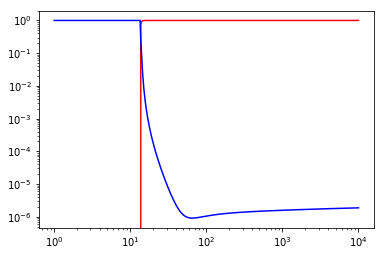

In [40]:
np.set_printoptions(threshold = np.nan)
#print(np.transpose([E_spec.eng, results_ion_frac_0[0,:],results_ion_frac_0[1,:]]))
plt.plot(E_spec.eng, results_ion_frac_0[0,:], 'r')
plt.plot(E_spec.eng, results_ion_frac_0[1,:], 'b')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [30]:
a=[0,1,2,3,4]
a[4]

4